# A multinomial naive Bayes classifier for goodreads reviews

In [27]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

*"A small fraction of Americans buy the vast majority of books in this country."*

Goodreads is the most popular online review site for books,  a social network for a devoted 16 million readers, with popular books containing millions of reviews. Amazon recently bought Goodreads for $150 million. They determined that the most influential readers were choosing their books based on Goodreads reviews, and now own the largest network of passionate book readers who make their purchase choices based on reviews written by other users.

Based on the 4 to 5 star reviews of some of the top 200 most popular books on Goodreads, we scrape several tens of thousands of reviews for 17 books and train classifier to predict the classes of new unseen text files within the 17 categories. For example, one could query "love story" and be matched to the Great Gatsby, since positive reviews for the book are the most likely to contain the words "love" or "story". Since almost all reviews are written by avid readers, they contain more information than summaries and also contain references to other books and authors, so it is not as transparent as classifying quotations from the actual books themselves. 


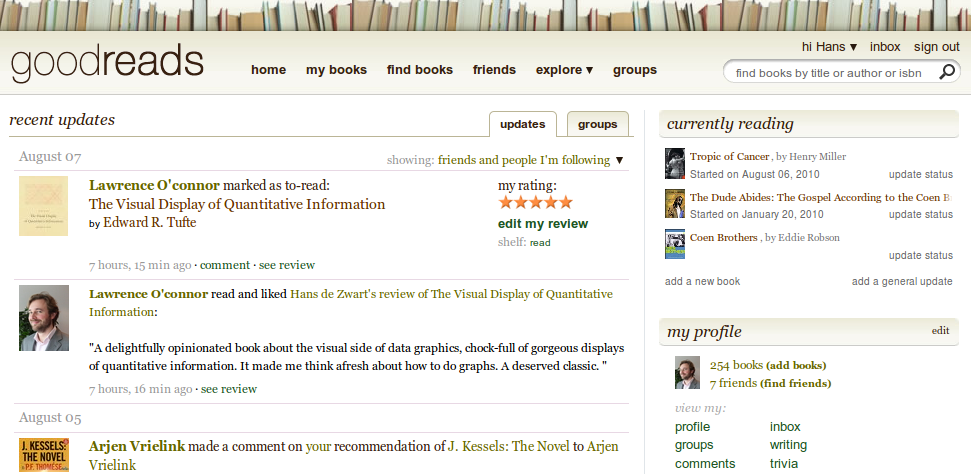

In [24]:

img = Image.open('/Users/bohun/Documents/scrapingproject/img/goodreadsshot.jpg')
img

# A few popular books

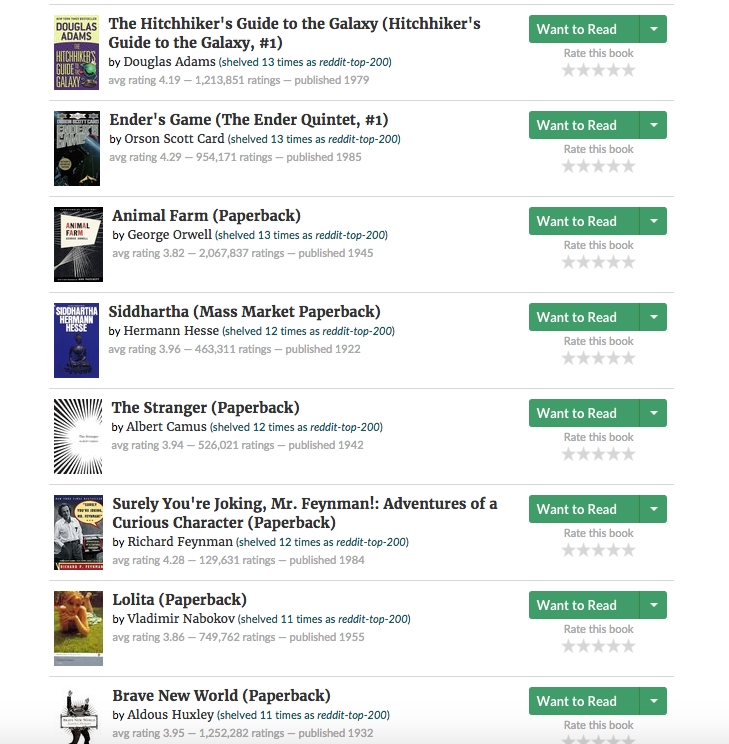

In [23]:

from PIL import Image
img1 = Image.open('/Users/bohun/Documents/scrapingproject/img/goodreads.png')
img1


The Great Gatsby, for instance, has nearly 800,000 reviews alone. They vary in length and are clearly not restricted to summary; each reader is free to share their feelings, personal opinions, and interpretations from the story which creates an extremely varied set of key words for the book text (as well as the sentiment of the reader), and references to other authors.

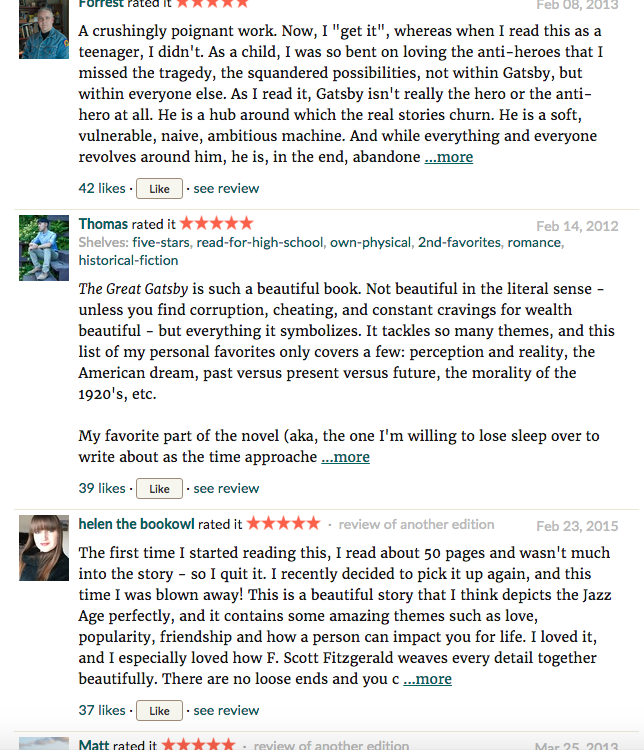

In [22]:

img2 = Image.open('/Users/bohun/Documents/scrapingproject/img/gatsby.jpg')
img2

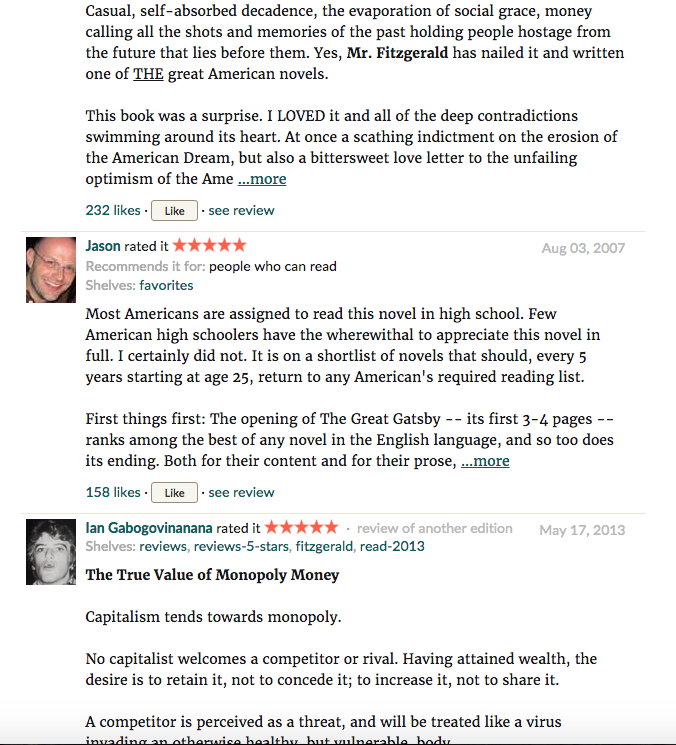

In [21]:

img2 = Image.open('/Users/bohun/Documents/scrapingproject/img/gatsby2.jpg')
img2

First we scrape the data using beautifulsoup and dryscrape.

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd 
import string 
import nltk 
import numpy as np 
import datetime as dt 
import time 
import unicodedata 
import re 
import requests
from selenium import webdriver
from nltk.corpus import stopwords
web_path = "http://www.goodreads.com/"

list_path = "https://www.goodreads.com/shelf/show/reddit-top-200"
listBook = BeautifulSoup(requests.get(list_path).text)
listTitle = listBook.find_all("a", class_ = "bookTitle")

href = []
title = []
for title in listTitle:
    href.append(web_path + title.get("href"))

rating = []
for link in href:
    book = BeautifulSoup(requests.get(link).text)
    rating.append(book.find("span", class_ = "average").string)
    #print book.find("h1", class_ = "bookTitle")
    if book.find("h1", class_ = "bookTitle").string != None:
         title.append(book.find("h1", class_ = "bookTitle").string)
    else:
        print book.find("h1", class_ = "bookTitle").contents[0].string
        title.append(book.find("h1", class_ = "bookTitle").contents[0].string)

To get the reviews into a dataframe, we can loop over the following function. We need the URL of the book and the resultant pandas dataframe is saved as a temp file, with columns indicating the user and the review text. We do this for the following subset of 17 top 100 books:
- **The Art Of War by Sun Tzu**
- **The Catcher in the Rye by J.D. Salinger**
- **Crime and Punishment by Fyodor Dostoyevsky**
- **Fear and Loathing in Las Vegas by Hunter S. Thompson**
- **The Girl on the Train by Paula Hawkins **
- **The Great Gatsby by F. Scott Fitzgerald**
- **The Hitchhiker's Guide to the Galaxy by Douglas Adams**
- **How to Win Friends and Influence People by Dale Carnegie**
- **Lolita by Vladimir Nabokov**
- **Surely You're Joking, Mr. Feynman!: Adventures of a Curious Character by Richard Feynman**
- **1984 by George Orwell**
- **The Giver by Louis Lowry**
- **Harry Potter and the Sorcerer's Stone by J.K. Rowling**
- **Slaughterhouse Five by Kurt Vonnegut**
- **Strange Case of Dr Jekyll and Mr Hyde by Robert Louis Stevenson**
- **Faust by Johann Wolfgang von Goethe **
- **The Iliad by Homer**

We have chosen as varied a selection as possible in order to train our classifer and account for as many queries as possible within the relatively small size of the set. A next step would be to download reviews for *all* books on goodreads and train a model on them. How many reviews have we scraped in total for these 17 books? Each book has about 5000 4 and 5 star reviews. That is 85,000 reviews just for 17 classes!

In [ ]:
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
import unicodedata

def get_reviews(url):
    browser = webdriver.Chrome("chromedriver")
    browser.get(url)
    time.sleep(2)
    reviews = {}
    i = 1

    while True:
        html_doc = browser.page_source
        soup = BeautifulSoup(html_doc, 'html.parser')
        rev_divs = None
        rev_divs = soup.findAll('div', {'class': 'left bodycol'})
        for rev_div in rev_divs:
            rev = None
            rev = rev_div.find('span', {'id': re.compile('freeText'), 'style': 'display:none'})
            user = rev_div.find('a', {'class': 'user'}).get('title')
            if not rev:
                rev = rev_div.find('span', {'id': re.compile('freeText')})

            if rev:
                rev = rev.text.encode('utf-8')
                #review = '\n'.join(filter(lambda s: len(s), map(lambda s: s.strip(), rev)))
            reviews[user] = rev
        
       
        try:
            i = i + 1
            linkElmt = browser.find_element_by_link_text(str(i))
            linkElmt.click()
            time.sleep(2)
            print "In page %d" %i
        except NoSuchElementException:
            break
        except StaleElementReferenceException:
            break
    resultdf = pd.DataFrame(reviews.items(), columns = ['user', 'review'])
    resultdf.to_csv('temp.csv', encoding='utf-8')
    return resultdf

The result for 4-5 star reviews of Girl on A Train is as follows. We have scraped also the user names, which might lend to an interesting future project where we use a gender algorithm to guess the genders of each user, and hence the proportion of reviewers for each book in each rating class who are male and female. We filter out reviews with ratings lower than 4 stars since they will not be useful for our recommendation system.

In [24]:
print len(girlontrain45star)
girlontrain45star.head(20)

4557


Unnamed: 0  \
  user                                          
4 John Nelson                               0   
  Adrianne                                  1   
  Annabel                                   2   
  Leah                                      3   
  The Just-About-Average Ms M               4   
  Burak                                     5   
  Jessica K                                 6   
  Trish                                     7   
  Bailey                                    8   
  Jayaram Vengayil                          9   
  Amrelsayed                               10   
  Sariithap' Williams                      11   
  Guillaume Tribulations d'une vie         12   
  Casey                                    13   
  Shirley                                  14   
  Arlene Hayman                            15   
  Annette Hall                             16   
  Deena                                    17   
  Elphaba J                                18   
  Paolo Aceves                             19   

                                                                               review  
  user                                                                                 
4 John Nelson                       Wow! What a hell of a way to quit drinking, Ra...  
  Adrianne                          People have compared this book to Gone Girl......  
  Annabel                           I really enjoyed this novel - a true thriller ...  
  Leah                              This is one of those books that I felt a littl...  
  The Just-About-Average Ms M       I have no idea why I am bothering to leave a r...  
  Burak                                    Her şeye rağmen güzeldi. Sevdim gerçekten.  
  Jessica K                          I gave it four stars because it was an origin...  
  Trish                             Read for a book club. One heck of a ride. Ever...  
  Bailey                            Fantastically fun thriller - definitely check ...  
  Jayaram Vengayil                  For someone who enjoys peeking into others' li...  
  Amrelsayed                        جمال الرواية في إبرازها لرؤيتنا المسبقة للأخري...  
  Sariithap' Williams               Una historia que te mantiene en suspenso todo ...  
  Guillaume Tribulations d'une vie  http://tribulationsdunevie.weebly.com...Le voy...  
  Casey                             First of all: stop with the Gone Girl comparis...  
  Shirley                           I'm sure many people mentioned this already bu...  
  Arlene Hayman                     It seems that I read ‘Girl on the Train’ recen...  
  Annette Hall                      A railway line runs past houses and trains reg...  
  Deena                             Will have you hooked from the start. Glad I go...  
  Elphaba J                         Opinião completa em: http://historiasdeelphaba...  
  Paolo Aceves                      Every year I try to read a book written from t...

We will now demonstrate word frequency tables for a subset of reviews from the first 12 books we scraped. This is for illustrative purposes: we will not train our model manually, but show what a word frequency matrix should look like for *n* categories.

In [48]:
import pandas as pd
import numpy as np
from unidecode import unidecode
girlontrain4star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/girlontrain4star.csv')
girlontrain5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/girlontrain5star.csv')
girlontrain4star = girlontrain4star.applymap(str)
girlontrain5star = girlontrain5star.applymap(str)
girlontrain4star = girlontrain4star.set_index('user')
girlontrain5star = girlontrain5star.set_index('user')

girlontrain45star = pd.concat([girlontrain4star, girlontrain5star], keys=['4', '5'])
catcher5star = pd.read_csv("/Users/bohun/Documents/scrapingproject/scraped_data/catcherrye5star.csv")
catcher5star = catcher5star.applymap(str)

In [49]:
gatsby5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/gatsby5star.csv')
gatsby5star = gatsby5star.set_index('user')
gatsby5star = gatsby5star.applymap(str)

In [51]:
hitchhiker5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/hitchhiker5star.csv')
hitchhiker5star = hitchhiker5star.set_index('user')
hitchhiker5star = hitchhiker5star.applymap(str)

In [54]:
howfriends5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/howfriends5star.csv')
howfriends4star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/howfriends4star.csv')
howfriends5star = howfriends5star.set_index('user')
howfriends4star = howfriends4star.set_index('user')
howfriends45star = pd.concat([howfriends4star, howfriends5star], keys=['4', '5'])

In [ ]:
giver5star = pd.read_csv('giver5star.csv')
giver5star = giver5star.set_index('user')
giver5star = giver5star.applymap(str)

In [ ]:
vegas5star = pd.read_csv('vegas5star.csv')
vegas5star = vegas5star.set_index('user')
vegas5star = vegas5star.applymap(str)

In [55]:
artofwar5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/artofwar5star.csv')
artofwar5star = artofwar5star.set_index('user')
artofwar5star = artofwar5star.applymap(str)

In [ ]:
feynman5star = pd.read_csv('feynman5star.csv')
feynman5star = feynman5star.set_index('user')
feynman5star = feynman5star.applymap(str)

In [52]:
crimepunish5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/crimepunish5star.csv')
crimepunish5star = crimepunish5star.set_index('user')
crimepunish5star = crimepunish5star.applymap(str)

In [35]:
orwell5star =  pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/orwell5star.csv')
orwell5star = orwell5star.applymap(str)
orwell5star = orwell5star.set_index('user')

lolita5star = pd.read_csv('/Users/bohun/Documents/scrapingproject/scraped_data/lolita5star.csv')
lolita5star = lolita5star.applymap(str)
lolita5star = lolita5star.set_index('user')

The next step is to clean up the reviews. We remove stop words (the most common English language words) since they are irrelevant for building our model. We can define our own stem function if we want to preserve (for instance) "community" instead of the default portStemmer which reduces it to "commun". For a word frequency table, we make sure that key words in the same review count only once, stem down the words, and save it as a dataframe.

In [441]:
import string
import re
punc = string.punctuation
from nltk.corpus import stopwords

stopwordz = stopwords.words('english')+[u'read',u'book', u'one']

def filter_stops(word_list):
    return [word for word in word_list if not word in stopwordz]

def stemw(word):
    for x in ['ing', 'ly', 'ies', 'ive', 's', 'ment']:
        if word.endswith(x): 
            return word[:-len(x)]
    for x in ['ed', 'es']:
        if word.endswith(x):
            return word[:-1]
    else: return word
    
def stemt(text):
    return [stemw(word) for word in text.split(" ")]


## set of words
lenr =len(hitchhiker5star)
wordlis=[]
for i in range(lenr):
    text = hitchhiker5star['review'].iloc[i] #text for a particular review
    text = text.lower() 
    words = re.findall(r'\w+', text) 
    words = list(set(words)) #the same words in one review count only once
    wordlis = wordlis + words
print "created word set length %i" % len(wordlis)

#remove the stops (applies to lists, not strings)
filtered_words = filter_stops(wordlis)
print "removed stops"

#get the stems
filtered_words = [stemw(word) for word in filtered_words]
print "stemmed down all words"

#word counter
freq_dict={}
for word in filtered_words:
    if word in freq_dict.keys():
        freq_dict[word]+=1
    else: freq_dict[word] =1
print "created freqdict length %i" %len(freq_dict)

 
hitchhiker5star = pd.DataFrame(freq_dict.items(), columns=['word', 'freq']).set_index('word').sort_values(by="freq", ascending=False)
print "created pdfdf"

created word set length 159948
removed stops
stemmed down all words
created freqdict length 13112
created pdfdf


We create book documents which are a compilation of all reviews. These will have several millions of words, and since order does not matter, we concatenate the text together from the reviews column and set the encoding. Once this is joined, we need to remove the special characters or else our model won't be able to parse the data. Here is the result for the gatsby data frame. This is not so interesting--*these words are frequent, but are they a good classifier for the novel review?* And how can we **contextualize** them?

In [26]:
gats = pd.read_csv("gatsby5starfreq.csv")
gats.head(20)

,word,freq
0,gatsby,1596
1,love,1505
2,time,1206
3,great,1205
4,character,1152
5,fitzgerald,1098
6,like,1042
7,daisy,968
8,novel,939
9,story,910


To do that, we join all reviews for each book together, and because of some Arabic/Chinese/Russian reviews, we must filter out special expressions before cohesing the file. We can do so with the following script:

In [57]:
traindoc = unidecode(" ".join(list(girlontrain45star['review'])).decode('utf8'))
catcherdoc = unidecode(" ".join(list(catcher5star['review'])).decode('utf8'))
gatsbydoc = unidecode(" ".join(list(gatsby5star['review'])).decode('utf8'))
hitchdoc = unidecode(" ".join(list(hitchhiker5star['review'])).decode('utf8'))
friendsdoc = unidecode(" ".join(list(howfriends45star['review'])).decode('utf8'))
feynmandoc = unidecode(" ".join(list(feynman5star['review'])).decode('utf8'))
crimedoc = unidecode(" ".join(list(crimepunish5star['review'])).decode('utf8'))
giverdoc = unidecode(" ".join(list(giver5star['review'])).decode('utf8'))
vegasdoc = unidecode(" ".join(list(vegas5star['review'])).decode('utf8'))
orwelldoc = unidecode(" ".join(list(orwell5star['review'])).decode('utf8'))
lolitadoc = unidecode(" ".join(list(lolita5star['review'])).decode('utf8'))
artwardoc = unidecode(" ".join(list(artofwar5star['review'])).decode('utf8'))

#We use the following script to filter special characters and save the concatenation as a text output.

with open('document.txt') as hand:
    lines = []
    for line in hand:
        lines.append(re.sub("[\W]", " ", line))

with open('document.txt', 'w') as hand:
    for line in lines:
        hand.write(line)

# Getting summaries of reviews based on chosen words
Let's pick out a word from the Gatsby frequency table and see in what context it appears. We can employ the power of regular expression:

In [62]:
re.findall(r'([^.]*romanticism[^.]*)', gatsbydoc)[1:20]

[' paint this picture of romanticism, of giving up everything, changing everything, for the love of one who barely deserves it, show us how beautiful and divine that is, let us bask in it, wish we had someone to love us that much, and then B',
 ' He also seems to have a sense of hopeless romanticism',
 ' The lyricism of the writing grows easier to appreciate and the romanticism of Nick Carraway and Jay Gatsby grows more apparent',
 ' The lyricism of the writing effectively conveys the romanticism in picturesque ruminations and scenes',
 " Fitzgerald laces his prose with romanticism, but he doesn't cheapen the characters or emotions in doing so",
 'The compelling message of Gatsby is the romanticism within us all - that there is an incorruptible truth out there somewhere, if only we can maintain the focus to seek it out and the courage to embrace it when we stumble across its path',
 " Drammatico e il romanticismo e l'inseguimento di un sogno che si fa piu grande della realta",
 'Dramat

What is the specificity of this word to Gatsby reviews? 

- Remark: the word 'romanticism' is only used in Gatsby reviews! This is remarkable since we are sieving through tens of thousands. This suggests a priori that it will be a good identifier for reviews in the Gatsby class.

In [65]:
re.findall(r'([^.]*disillusion[^.]*)', gatsbydoc)[1:10]

[" I'm still reeling from Gatsby's disillusionment, and my own subsequent questioning of my values and goals",
 " Gatsby's disillusionment had a huge impact on how I view my own dreams, and so for that reason (and also because he's adorable) he made my fave character of this book",
 ' The Great Gatsby is not the only story of its kind or the only story about disillusionment',
 ' Tying in with my first takeaway, my second would be to keep our hopes realistic so that we do not find ourselves disillusioned',
 ' I also learned that the disillusionment in the air during this time is present in our world as well',
 "But then again, it's plausible that Jay Gatsby has become so disillusioned by his way of life, by the character that he has become and the world he has adopted, that he no longer knows what is real and what is happening before him",
 "But first and foremost, it is a story of disillusionment with dreams that prove to be shallow and unworthy of the dreamer - while at the same time 

Let's see how many users commented that Nabokov is a lyrical writer.

In [63]:
re.findall(r'([^.]*lyric[^.]*)', lolitadoc)[1:20]

[' Nabokov is a lyricist and a word-magician',
 '4) Voice (5 stars) - The story is told in the frantic, fervent, lyrical, lustful voice of the main character pleading his case as if to a jury',
 ' Updates from the re readFound it a marvelous and lyrical narration of the vagaries of an abnormal mind',
 ' It was magical, lyrical, very touching',
 ' The names chosen for the hero-villain and his child amour were superb - Humbert and Dolores/Lolita - the names are lyrical and I can roll my tongue around them easily and repeatedly',
 ' Is lyrical with a purpose',
 '"Throughout this brilliant, perfect, lyrical novel, Nabakov alternates between lies, fantasies, funny stories and fabrications',
 ' His is alliterative, and hauntingly lyrical and I always always always have to read passages aloud to myself because of how pretty they sound when spoken',
 'Nabokov paints everything up with such beautiful language, phrases and similes and I absolutely adored reading the ryhymes, the lyrics and the c

In the final two examples we test whether reviews have key words that reference relations to other authors. For instance, "Machiavelli" is more likely to appear in a review for the Art of War than in a review for How to Win Friends and Influence People, whereas "purgatory" is more likely to appear in a Crime and Punishment review than any other.

In [60]:
re.findall(r'([^.]*purgatory[^.]*)', crimedoc)

[" I lived the humiliation and spiritual purgatory of being a real-life Marmeladov, though I'm happy to have experienced something of redemption",
 ' But he met Sonya who pushed him further to purgatory, on his journey of religious redemption']

In [62]:
re.findall(r'([^.]*Machiavelli[^.]*)', artwardoc)

[' I like Machiavelli\'s "The Prince" more than this',
 " I greatly enjoyed this book and recommend it too everyone - also I've found Machiavelli's Prince is a great read afterwards",
 " Absolutely fantastic, along with Machiavelli's the Prince, is a great book to study psychological manipulation and deception The Art of War is an extremely quick read, and it is well worth your time",
 ' Sun Tze\'s use of "dao" anticipates, some 2000 years before the fact, Machiavelli\'s use of "virtu',
 "Niccolo Machiavelli, in The Prince says if you are in a position of power and seek to maintain it, it is better to be loved and respected, but if you can't achieve that, then at least enforce respect and these are the, often brutal, strategies that will get that result",
 " The Art of War reminds me of Machiavelli's Prince with regard to its focus on strategic thinking and planning",
 " Perhaps it is book's realism (as against the bookish morality) - something comparable to Machiavelli's 'The Prince'"

We will now create a table of all words and their 'scores' for each book. What we mean by scores is the following: we don't account just for occurences of the words, but for *frequency*. Note that we change all NaNs to zeros to get a word vector for each book: if a word in one review does not appear in another book's review list, it has a score of zero for the latter book.


In [59]:
girltrain = pd.read_csv("girlontrain45swordfreq.csv")
girltrain = girltrain[girltrain['freq']>6]
sumword1 = sum(girltrain['freq'])
girltrain['prop'] = girltrain['freq']/sumword1

orwell = pd.read_csv("orwell5starfreq.csv")
orwell = orwell[orwell['freq']>6]
sumword2 = sum(orwell['freq'])
orwell['prop'] = orwell['freq']/sumword2

catcher = pd.read_csv("catcher5starfreq.csv")
catcher = catcher[catcher['freq']>6]
sumword3 = sum(catcher['freq'])
catcher['prop'] = catcher['freq']/sumword3

crimepunish = pd.read_csv("crimepunish5starfreq.csv")
crimepunish = crimepunish[crimepunish['freq']>6]
sumword4 = sum(crimepunish['freq'])
crimepunish['prop'] = crimepunish['freq']/sumword4

lolita = pd.read_csv("lolita5starfreq.csv")
lolita = lolita[lolita['freq']>6]
sumword5 = sum(lolita['freq'])
lolita['prop'] = lolita['freq']/sumword5

gatsby = pd.read_csv("gatsby5starfreq.csv")
gatsby = gatsby[gatsby['freq']>6]
sumword6 = sum(gatsby['freq'])
gatsby['prop'] = gatsby['freq']/sumword6

feynman = pd.read_csv("feynman5starfreq.csv")
feynman = feynman[feynman['freq']>6]
sumword7 = sum(feynman['freq'])
feynman['prop'] = feynman['freq']/sumword7

giver = pd.read_csv("giver5starfreq.csv")
giver = giver[giver['freq']>6]
sumword8 = sum(giver['freq'])
giver['prop'] = giver['freq']/sumword8

artwar = pd.read_csv("artofwar5starfreq.csv")
artwar = artwar[artwar['freq']>6]
sumword9 = sum(artwar['freq'])
artwar['prop'] = artwar['freq']/sumword9

vegas = pd.read_csv("vegas5starfreq.csv")
vegas = vegas[vegas['freq']>6]
sumword10 = sum(vegas['freq'])
vegas['prop'] = vegas['freq']/sumword10

friends = pd.read_csv("howfriends45starfreq.csv")
friends = friends[friends['freq']>6]
sumword11 = sum(friends['freq'])
friends['prop'] = friends['freq']/sumword11

hitchhike = pd.read_csv("hitchhiker5starfreq.csv")
hitchhike = hitchhike[hitchhike['freq']>6]
sumword12 = sum(hitchhike['freq'])
hitchhike['prop'] = hitchhike['freq']/sumword12

temp = pd.merge(girltrain, orwell,  how='outer', on=['word'], suffixes=('_grltrain', '_orwell'))
temp = pd.merge(temp, crimepunish,  how='outer', on=['word'] )
temp.rename(columns={'freq': 'freq_crime', 'prop': 'prop_crime'}, inplace=True)
temp = pd.merge(temp, lolita5star, how='outer', on='word')
temp.rename(columns={'freq': 'freq_lolita', 'prop': 'prop_lolita'}, inplace=True)
temp = pd.merge(temp, catcher, how='outer', on='word')
temp.rename(columns={'freq': 'freq_catcher', 'prop': 'prop_catcher'}, inplace=True)
temp = pd.merge(temp, gatsby, how='outer', on='word')
temp.rename(columns={'freq': 'freq_gatsby', 'prop': 'prop_gatsby'}, inplace=True)
temp = pd.merge(temp, feynman, how='outer', on='word')
temp.rename(columns={'freq': 'freq_feynman', 'prop': 'prop_feynman'}, inplace=True)
temp = pd.merge(temp, giver, how='outer', on='word')
temp.rename(columns={'freq': 'freq_giver', 'prop': 'prop_giver'}, inplace=True)
temp = pd.merge(temp, artwar, how='outer', on='word')
temp.rename(columns={'freq': 'freq_artwar', 'prop': 'prop_artwar'}, inplace=True)
temp = pd.merge(temp, vegas, how='outer', on='word')
temp.rename(columns={'freq': 'freq_vegas', 'prop': 'prop_vegas'}, inplace=True)
temp = pd.merge(temp, friends, how='outer', on='word')
temp.rename(columns={'freq': 'freq_friends', 'prop': 'prop_friends'}, inplace=True)
temp = pd.merge(temp, hitchhike, how='outer', on='word')
temp.rename(columns={'freq': 'freq_hitchhike', 'prop': 'prop_hitchhike'}, inplace=True)

temp.fillna(0, inplace=True)

temp = temp.set_index('word')

# temp = temp.transpose()
print len(temp)
temp.head(10)

# tf-idf scores: going from occurences to frequencies

The output is a word table with 7819 words. Each book class corresponds to a vector of those words: entries for which the frequency is not zero, and entries for which it is zero. The list of 7819 words are all non-stop words used among all book reviews. Now that we have the word proportions between their book review classes, we are ready to score them.

Occurrence count is a good start for classifying how important words are in identifying books but there is an issue. Longer review documents will have higher average count values than shorter documents, even though they may agree on the sentiment. To avoid this discrepancy one divide the number of occurrences of each word in a document by the total number of words in the document: these new values are called term frequencies. Another refinement is to downscale weights for words that occur in many reviews across all books and are therefore poorer classifiers. This downscaling is called tf–idf, or “Term Frequency times Inverse Document Frequency”.

We need three variables: the term frequency, which is the proportion of 'word' within its book class, the 'n_containing', which is the number of documents contaning 'word', and the 'idf': the inverse document frequency. The idf measures how common 'word' is among all reviews in a book list. The more common 'word' is, the lower its idf. It is the log of the ratio of the total number of books to n_containing. Together, the tf and idf react positively to higher relevance. Whereas tf uses local information, idf takes a global perspective. Finally, the tf-idf of 'word' within a review class within a book class is simply the product of tf and idf. 

In [697]:
seq = temp.sum(axis=0, numeric_only=True)/2

#make a global dictionary of all words scoring the number of books whose reviews contain them.
numwords = sum(seq[::2])
wordlist = list(temp.index)

#calculate n_containing for each word
numcontaindict = {}
for word in wordlist:
     numcontaindict[word] = sum(temp.loc[word]!=0)/2
numcontaindict = pd.DataFrame.from_dict(numcontaindict, orient='index')

numcontaindict.index.names = ['word']
temp = temp.merge(numcontaindict, left_index=True, right_index=True)
temp.rename(columns = {list(temp)[24]:'ncontain'},inplace=True)

#compute the idf of each word. we compute for 12 documents in total.
temp['idf'] = math.log(12)/(1 + temp['ncontain'])
temp.to_csv("ntable.csv")


In [734]:
temp['tfidfgrltrain'] = temp['prop_grltrain']*temp['idf']
temp['tfidforwell'] = temp['prop_orwell']*temp['idf']
temp['tfidfcrime'] = temp['prop_crime']*temp['idf']
temp['tfidflolita'] = temp['prop_lolita']*temp['idf']
temp['tfidfcatcher'] = temp['prop_catcher']*temp['idf']
temp['tfidfgatsby'] = temp['prop_gatsby']*temp['idf']
temp['tfidffeynman'] = temp['prop_feynman']*temp['idf']
temp['tfidfgiver'] = temp['prop_giver']*temp['idf']
temp['tfidfartwar'] = temp['prop_artwar']*temp['idf']
temp['tfidfvegas'] = temp['prop_vegas']*temp['idf']
temp['tfidffriends'] = temp['prop_friends']*temp['idf']
temp['tfidfhitchhike'] = temp['prop_hitchhike']*temp['idf']

scores = temp.iloc[:,26:38]

girltrain =  scores['tfidfgrltrain']
girltrain = girltrain.sort_values(inplace=False, ascending=False)
orwell = scores['tfidforwell']
orwell = orwell.sort_values(inplace=False, ascending=False)
crime = scores['tfidfcrime']
crime = crime.sort_values(inplace=False, ascending=False)
lolita = scores['tfidflolita']
lolita = lolita.sort_values(inplace=False, ascending=False)
catcher = scores['tfidfcatcher']
catcher = catcher.sort_values(inplace=False, ascending=False)
gatsby = scores['tfidfgatsby']
gatsby = gatsby.sort_values(inplace=False, ascending=False)
feynman = scores['tfidffeynman']
feynman = feynman.sort_values(inplace=False, ascending=False)
giver = scores['tfidfgiver']
giver = giver.sort_values(inplace=False, ascending=False)
artwar = scores['tfidfartwar']
artwar = artwar.sort_values(inplace=False, ascending=False)
vegas = scores['tfidfvegas']
vegas = vegas.sort_values(inplace=False, ascending=False)
friends = scores['tfidffriends']
friends = friends.sort_values(inplace=False, ascending=False)
hitch = scores['tfidfhitchhike']
hitch = hitch.sort_values(inplace=False, ascending=False)

tdif = scores.transpose()
tdif

word,0,convolute,foul,narcotic,four,shamble,surpasse,conjure,otro,authorit,...,svidrigailov,kinda,cliff,suppres,experienc,pode,jewel,podr,ideological,irony
tfidfgrltrain,0.000022,0.000049,0.000022,0.00000,0.000115,0.000066,0.000000,0.000019,0.000023,0.0000,...,0.000000,0.000038,0.000000,0.000000,0.000017,0.000040,0.000000,0.000044,0.0000,0.000000
tfidforwell,0.000000,0.000000,0.000000,0.00000,0.000211,0.000000,0.000000,0.000000,0.000052,0.0001,...,0.000000,0.000019,0.000000,0.000044,0.000000,0.000089,0.000000,0.000105,0.0001,0.000026
tfidfcrime,0.000031,0.000000,0.000000,0.00000,0.000051,0.000000,0.000000,0.000000,0.000064,0.0000,...,0.001019,0.000047,0.000038,0.000000,0.000046,0.000000,0.000000,0.000000,0.0000,0.000000
tfidflolita,0.000000,0.000000,0.000030,0.00000,0.000135,0.000000,0.000000,0.000074,0.000021,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000051
tfidfcatcher,0.000031,0.000000,0.000050,0.00000,0.000068,0.000000,0.000000,0.000000,0.000018,0.0000,...,0.000000,0.000047,0.000339,0.000000,0.000056,0.000000,0.000000,0.000000,0.0000,0.000040
tfidfgatsby,0.000000,0.000000,0.000060,0.00000,0.000080,0.000000,0.000061,0.000027,0.000020,0.0000,...,0.000000,0.000012,0.000030,0.000000,0.000029,0.000000,0.000047,0.000000,0.0000,0.000047
tfidffeynman,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
tfidfgiver,0.000032,0.000000,0.000000,0.00000,0.000072,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000040,0.000045,0.000058,0.000086,0.000000,0.000000,0.000000,0.0000,0.000018
tfidfartwar,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
tfidfvegas,0.000000,0.000000,0.000000,0.00096,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000


We now have the following matrix of words. Each book has a tf-idf score for each of the 7819 words. Note that most entries are zero: the intersection of words between all books cannot be dense. Words with high scores mean that that word is a more unique identifier for the corresponding book, and words with zero scores mean that they are not unique to that particular book. Note that we have filtered out words appearing less than 7 times, this is simply to demonstrate how vectorization and transformation occurs for a collective word list. Had we kept all words in all documents, the matrix would be over a hundred thousand columns wide.

Remark: the words with the highest tf-idf scores for the Great Gatsby are Fitzgerald, Gatsby, Daisy, Nick, Jay, Carraway, Buchanan, 1920, love, jazz, time, egg, roar, dream, and ceaseless. The first few are obvious, the non-name words are good identifiers.

Let us run the following demo. We start with a string of words "all great and precious things are lonely." We compute the tf-idf score for each of the words. Since 'all' is a stopword, it will be discarded. Great, precious, thing and lonely will be stemmed, and their tf-idfs can be computed based on the number of books that contain them, as well as their frequency within the string. This results in vectorizing the string into an array composed of all zeros on the 7815 word entries which are not contained in the string, and 4 entries corresponding to the scores of the 4 words.

In [10]:
import nltk
import string
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

path = './books'
token_dict = {}

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

for dirpath, dirs, files in os.walk(path):
    for f in files:
        fname = os.path.join(dirpath, f)
#        print "fname=", fname
        with open(fname) as pearl:
            text = pearl.read()
            token_dict[f] = text.lower().translate(None, string.punctuation)

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
tfs = tfidf.fit_transform(token_dict.values())

str = 'all great and precious things are lonely.'
response = tfidf.transform([str])
print response

feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    print feature_names[col], ' - ', response[0, col]

  (0, 101449)	0.458181810641
  (0, 79952)	0.56649084899
  (0, 58090)	0.509143373526
  (0, 39239)	0.458181810641
thing  -  0.458181810641
preciou  -  0.56649084899
lone  -  0.509143373526
great  -  0.458181810641


The tdf-idf scores are quite high since each word has a relatively high term frequency and inverse document frequency. However, the term which is the best classifier for the string is "precious": it has the highest tf-idf. The string is now vectorized into a 4 length vector of its tfidf. The next step is to transform this vector into a feature vector with zeros everywhere else in order to classify this as one of the target values (the books).

# A naive Bayes classifier

We will now exclusively use the scikit learn package to build a multinomial naive Bayes classifier for 17 book review sets in total. 

Note that we must also keep a portion (about 10%) of reviews in our test set. We take separate these text files so that we do not test on the same data we train on, otherwise it would be meaningless. The goal is to evaluate the accuracy of the model in classifying the newly unseen reviews. 

We wish to train our model on reviews for which we have the categories (the 17 books) in order to predict which category a query would fall under. We load the training set, the compilation of all reviews for each of the 17 books, and we vectorize and transform our count matrix to a tf-idf representation. The resultant matrix book_train_counts represents 17 categories with a unique 150,000+ long vector of word tf-idf scores. The training set is an object called a sklearn.datasets.base.Bunch. This is a simple holder object with fields that can be both accessed as dictionary keys or object attributes, for instance the target_names holds the list of the book names. It also contains a dictionary of all reviews (values) with keys given by the categories. Lastly, the target names of the training set are transformed into a 17-length array. 

We now turn the review text content into numerical feature vectors by using count vectorization. For this we call upon a **'bag of words'** representation: we can, (by using a dictionary of words to indices), assign a fixed integer ID to each word occurring in any review set of any category. Take each review ```i``` in categories 1-17, count the absolute number of occurrences of ```word```, and store it in the matrix ```book_train_counts[i, j]``` as the feature value ```j``` where ```j``` is the index of ```word``` in the dictionary. We don't need to worry about computing tf-idf for each word individually, the scikit learn transformer will do that for us.


In [32]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


categories = ['artofwar', 'catcherintherye','crimepunishment', 'fearloathinglasvegas', 'girlontrain', 'greatgatsby',\
              'hitchhiker', 'howtomakefriends', 'lolitabk', 'mrfeynman', 'orwell1984', 'thegiver', 'originofspecies', \
             'faust', 'slaughterhouse5', 'iliad', 'harrypotter1', 'jekyllhyde']


trainingset =  load_files(container_path = '/Users/bohun/Documents/scrapingproject/books', \
                        categories=categories, shuffle=False,\
                          load_content=True, decode_error='ignore',\
                         encoding="utf-8")

count_vect = CountVectorizer()
book_train_counts = count_vect.fit_transform(trainingset.data)
book_train_counts.shape

(18, 144180)

In [33]:
trainingset.target

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

Subsequently, we call the fit method to fit our naive Bayes estimator to the data and then transform the ```book_train_counts``` matrix to a tf-idf representation. After we have our feature vectors, we can train the classifier ```clf``` to predict the category of a query (or more generally a longer document.)

In [34]:
tfidf_transformer = TfidfTransformer()
book_train_tfidf = tfidf_transformer.fit_transform(book_train_counts)
book_train_tfidf.shape

(18, 144180)

Naive Bayes models the distribution of words in each document as a multinomial. As we have demonstrated, the document is vectorized to a sequence of words and one should note the assumption that each word position is generated independently of every other. The goal is classification based on a fixed number of categories.

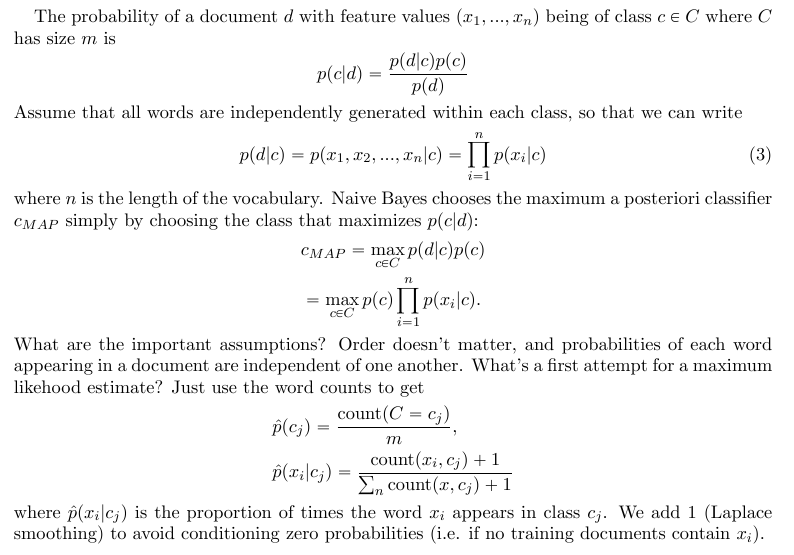

In [64]:
img4 = Image.open('/Users/bohun/Documents/scrapingproject/img/bayes.jpg')
img4

Bayes theorem  expresses the likelihood ```p(c|d)``` of a document belonging to class ```c``` as a function of the words in ```c``` and their frequencies. One obtains the classification rule selecting the category ```c``` with the maximum (posteriori) likelihood. We can thus fit our MNB model classifer ```clf``` using the target values of the training set and their tfidf matrix. Note that the probability estimator of ```p(x[i]|c)``` is a crude estimate since it relies on word counts and not term frequencies. However the scikit toolbox allows us to transform to tf-idf before selecting a Bayesian classifier. Still, the idea is the same. Given a sentence (or document), how do we choose a class?

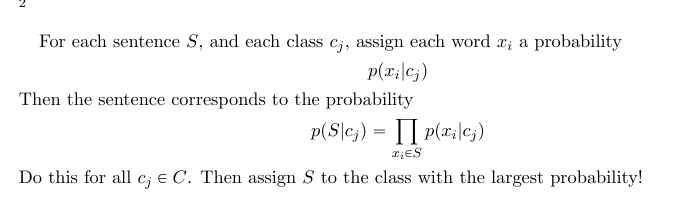

In [5]:
img7 = Image.open('/Users/bohun/Documents/scrapingproject/img/bayesclass.jpg')
img7

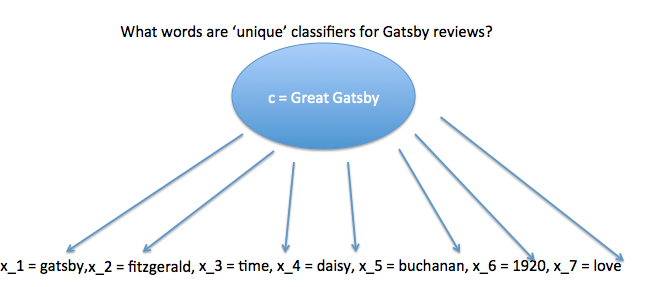

In [74]:
img5 = Image.open('/Users/bohun/Documents/scrapingproject/img/gatsbyc.jpg')
img5

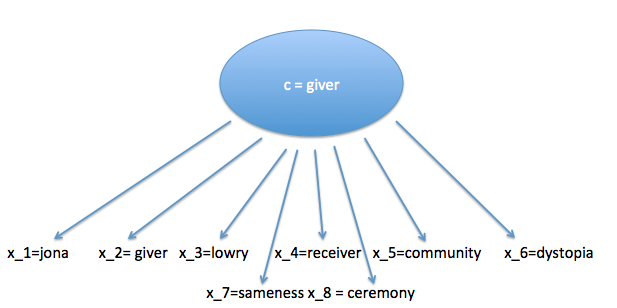

In [73]:
img6 = Image.open('/Users/bohun/Documents/scrapingproject/img/giver.jpg')
img6

In [37]:
clf = MultinomialNB().fit(book_train_tfidf, trainingset.target)

# Applying the model: predictions from queries

Now the fun part: we can test our model on queries that return matched book reviews. MNB vectorizes the words from our query, transforms it into tf-idf scores, and then applies the Bayes classifer to assign the string to the set of book reviews which it is most likely to be contained in. Each string is matched to the book for which it is most likely to have been a (positive) review for.

In [77]:
docs_new = ['fitzgerald',\
            'sex', 'romanticize', 'the giver', 'physics', \
            'this sentence has unseen text such as computer which I am using to trick it but also king jazz wealth novel mansion light romanticism island past.',
           'egomaniac,'
           'whiny teenager',
           'mercy',
           'raskolnikov',
           'redemption',
           'ceaseless dream boats against the current',
           'daisy',
           'friends social network',
           'pathetic',
           'thriller suspense mystery',
           'war and peace',
           'love story',
           'comedy',
           'characters who sin and are redeemed',
           'learn about the universe and science',
           'manhattan project',
           'apathy and indifference',
           'society living under dystopian community',
           'brave new world',
           'titanic',
           'erotic old man pervert and and young nymphet sex',
           'annoying society anger rage violence',
           'irony',
           'machiavelli',
           'forgiveness, peace, tolerance and equanimity',
           'hypocrisy',
           'ayn rand',
           'communist propaganda',
           'pretentious arrogant self-centered',
            'naturalism',
           'academic nonsense',
           'heroes who falter and fall',
           'triumph of good over evil',
           'villain who searches for truth',
           'capitalism, wealth and the american dream, romance',
           'leonardo dicaprio',
           'johnny depp',
           'extraordinary perseverance',
           'baz luhrmann',
           'filthy rich','loneliness',
           'lyricism',
           'ideological',
            'all great and precious things are lonely',
           'idealism, the pursuit of the dream, the loss of the dream',
           'jane eyre',
           'harry potter',
           'ancient egyptian history',
           'sorcery wand magic',
           'two faces',
           'evolution natural selection',
           'sell your soul',
           'devil soul']

book_new_counts = count_vect.transform(docs_new)
book_new_tfidf = tfidf_transformer.transform(book_new_counts)

predicted = clf.predict(book_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, trainingset.target_names[category]))

'fitzgerald' => greatgatsby
'sex' => lolitabk
'romanticize' => slaughterhouse5
'the giver' => thegiver
'physics' => mrfeynman
'this sentence has unseen text such as computer which I am using to trick it but also king jazz wealth novel mansion light romanticism island past.' => howtomakefriends
'egomaniac,whiny teenager' => catcherintherye
'mercy' => iliad
'raskolnikov' => crimepunishment
'redemption' => crimepunishment
'ceaseless dream boats against the current' => iliad
'daisy' => greatgatsby
'friends social network' => howtomakefriends
'pathetic' => girlontrain
'thriller suspense mystery' => girlontrain
'war and peace' => artofwar
'love story' => jekyllhyde
'comedy' => hitchhiker
'characters who sin and are redeemed' => girlontrain
'learn about the universe and science' => hitchhiker
'manhattan project' => mrfeynman
'apathy and indifference' => crimepunishment
'society living under dystopian community' => thegiver
'brave new world' => thegiver
'titanic' => greatgatsby
'erotic old man

# Testing our model

 We employ a Pipeline class from the scikit-learn library in order to make the vectorization => transformation => classifer faster to implement. We create a test set of 12 book categories with new reviews 'hidden' from the previous ones and get the percentage of correct predictions.

In [45]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),\
                      ('tfidf', TfidfTransformer()),\
                      ('clf', MultinomialNB()),])
testset =  load_files(container_path = '/Users/bohun/Documents/scrapingproject/test', \
                      shuffle=True, categories = categories, \
                     load_content=True, decode_error='ignore',\
                     encoding="utf-8")

text_clf = text_clf.fit(trainingset.data, trainingset.target)

testpredicted = text_clf.predict(testset.data)
np.mean(testpredicted == testset.target) 

0.88235294117647056

Our model has 88% accuracy. This is very good but may decrease if we had more than 12 categories and 'intersectional' reviews thereby decreasing the tf-idf scores of key words. However, naive Bayes works well in this case because we do not need an actual estimate of probabilities, simply a maximum likelihood estimator that assigns us to a category.

# Conclusion
Goodreads is a large mine of data. The reviews provide summaries, quotations, and character names, but also parallel themes to other books or authors. This makes a simple MNB classifer a very powerful tool when trained on classes which encompass this depth of data. The next task is to scrape goodreads for more books and create a larger training set. One of the assumptions of our MNB model is that each word is generated independently of the next, order does not matter (we use a **bag of words** representation) and the number of distinct reviews for each book does not matter since the model is trained on the set of the whole. 

If we make the additional assumption that the compiled document of all positive reviews for a single book will contain quotation text from the book itself, the MNB classifier assigns a most likely book for each query to have been extracted from. This may also be true for negative reviews.


Whereas we scraped data in tabular form to demonstrate how the vectorization => transformation => classification process works, for further development (for example scraping thousands more books) we would compile only the filtered text files. 

To increase efficiency of our scraper we could employ a more concise script:

In [ ]:
def get_reviews_text(url):
    browser = webdriver.Chrome("/Users/bohun/Downloads/chromedriver")
    browser.get(url)
    time.sleep(2)
    reviews = []
    i = 1

    while True:
        html_doc = browser.page_source
        soup = BeautifulSoup(html_doc, 'html.parser')
        rev_divs = None
        rev_divs = soup.findAll('div', {'class': 'left bodycol'})
        for rev_div in rev_divs:
            rev = None
            rev = rev_div.find('span', {'id': re.compile('freeText'), 'style': 'display:none'})
            if not rev:
                rev = rev_div.find('span', {'id': re.compile('freeText')})

            if rev:
                rev = rev.text.encode('utf-8')
            reviews.append(rev)
        
    
        try:
            i = i + 1
            linkElmt = browser.find_element_by_link_text(str(i))
            linkElmt.click()
            time.sleep(2)
            print "In page %d" %i
        except NoSuchElementException:
            break
        except StaleElementReferenceException:
            break

    doc = unidecode(" ".join(reviews).decode('utf8'))    
    print "made string of reviews"

    with open('document.txt', 'w') as f:
        lines = doc
        filtlines = []
        for line in lines:
            filtlines.append(re.sub("[\W]", " ", line))
        for line in filtlines:
            f.write(line)
    print "made text file of all reviews"